# Position tracking

The classes for object (arena, bridge, mouse lever) detections are in the autopipy package.

There are a few steps in this procedure to go from the raw video of the arena to the position of the animal. 

Steps with the `arena_top.avi` file

* Detect the bridge and arena in arena_top.avi
* Crop the arena_top.avi to 480x480

Steps with the cropped video

* Detect arena in cropped video
* Detect bridge in cropped video
* Detect the mouse and lever in cropped video

There is a jupyter notebook in `autopi_analysis/kevin/autopipy_dev_notebooks` in which all the steps for a single session are performed separately. This is a good place to go if you have problems running the analysis on one session.

Below is the code to run the analysis on several sessions. 

It takes approximately **30 minutes per session** with a decent GPU. You can of course run different sessions on different GPU to speed up the process.

You will need to run this code from a DLC-GPU virtual environment.

In [1]:
%load_ext autoreload
%autoreload 2
import os
os.environ["DLClight"]="True" # if you don't need dlb gui
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import os.path
import autopipy
import importlib
from autopipy.project import Project
from autopipy.video_utilities import positionTrackingFromArenaTopVideo
%matplotlib inline

DLC loaded in light mode; you cannot use any GUI (labeling, relabeling and standalone GUI)


Let's get our project with the list of sessions

In [2]:
projectName="autopi_ca1"
dataPath="/adata/projects/autopi_ca1"
dlcModelPath="/adata/models"
bridgeModel1 ="bridgeDetection_640_480-Allen-2021-02-10"
mouseLeverModel ="arena_top-Allen-2019-10-30"
bridgeModel2 = "bridgeDetection_480_480-Allen-2021-01-23"
arenaMinRadius= 190
arenaMaxRadius= 260


myProject = Project(name=projectName,dataPath=dataPath,dlcModelPath=dlcModelPath)
fn=myProject.dataPath+"/sessionList"
print("Reading " + fn)
sessionNames = pd.read_csv(fn) # this will be a pandas dataframe
print("We have {} testing sessions in the list".format(len(sessionNames)))
myProject.createSessionList(sessionNameList=sessionNames.sessionName.to_list()) 

Project name: autopi_ca1
dataPath: /adata/projects/autopi_ca1
dlcModelPath: /adata/models
Reading /adata/projects/autopi_ca1/sessionList
We have 40 testing sessions in the list


The function doing all the video processing and object tracking is in the file `video_utilities.py` of the `autopipy` package. 
The function is called `positionTrackingFromArenaTopVideo`.
It relies on a 3 trained deeplabcut models to detect 

* 1) the bridge in 680x480 videos
* 2) the mouse and lever in 480x480 videos
* 3) the bridge in 480x480 videos

You can set the path where these models are found and the name of the deeplabcut models via the function arguments.


## Retraining dlc models

Because we are using a different recording setup, I had to retrain the DLC networks to get good performance.

### Bridge 680x480

For bridge detection, the first few frames are very unreliable. There are session in which the bridge is not visible at the beginning. We will select random frames instead.

I chose 50 random frames from 5 randomly picked sessions and labelled some frames.

In [3]:
ofn= "/home/kevin/Downloads/electroAutopiVideo.avi"
fps=30
inWidth=640
inHeight=480
nSelect=50

out = cv2.VideoWriter(ofn, cv2.VideoWriter_fourcc(*'MJPG'), fps, (inWidth,inHeight)) 

for i in 5,10,20,30: # arbitrary selected indices for sessions
    ses = myProject.sessionList[i]
    ifn = ses.fileNames["arena_top.avi"]
    print(ifn)
    if not os.path.exists(ifn):
        print("file missing")
        
    cap = cv2.VideoCapture(ifn)
    fps = int (cap.get(cv2.CAP_PROP_FPS))
    width = int (cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int (cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    nFrames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    selectIndices = np.sort(np.random.randint(0,nFrames-1,nSelect))
    
    # get random frames
    for i in selectIndices:
        cap.set(cv2.CAP_PROP_POS_FRAMES,i)
        ret, frame = cap.read()
        out.write(frame)
    cap.release() 
    
out.release()
print("Merged video:",ofn)

/adata/projects/autopi_ca1/mn711/mn711-30012021-0106/mn711-30012021-0106.arena_top.avi
/adata/projects/autopi_ca1/mn711/mn711-04022021-0107/mn711-04022021-0107.arena_top.avi
/adata/projects/autopi_ca1/mn1173/mn1173-02052021-0107/mn1173-02052021-0107.arena_top.avi
/adata/projects/autopi_ca1/mn5618/mn5618-07072021-0107/mn5618-07072021-0107.arena_top.avi
Merged video: /home/kevin/Downloads/electroAutopiVideo.avi


I then added /home/kevin/Downloads/electroAutopiVideo.avi to the dlc project, labelled the frames, and retrained.

## Arena detection

We also had problems with the arena detection in the 640x480 arena top videos. This was affecting the first 6 sessions of the project.

In [3]:
len(myProject.sessionList)

44

0 /adata/projects/autopi_ca1/mn9686/mn9686-01112021-0106/mn9686-01112021-0106.arena_top.avi
[234 244 222]
labelImage: /adata/projects/autopi_ca1/mn9686/mn9686-01112021-0106/arenaDetection.png


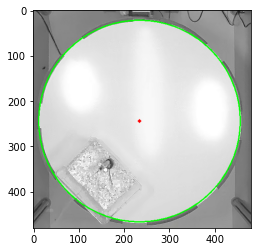

In [5]:
from autopipy.cvObjectDetectors import ArenaDetector

for i,ses in enumerate(myProject.sessionList[43:]):
    videoFile = ses.fileNames["arena_top.avi"] #Nice trick to get file names using a dict
    arenaImageFile=ses.path+"/arenaDetection.png"
    print(i, videoFile)
    arenaMinRadius=140 # 190 for most sessions
    arenaMaxRadius=230
    numFramesArenaDetection=100
    arenaCircleMethod="median"
    arenaD = ArenaDetector()
    aCoord = arenaD.detectArenaCoordinates(pathVideoFile=videoFile, minRadius=arenaMinRadius, 
                                  maxRadius=arenaMaxRadius, numFrames=numFramesArenaDetection, blur=11, circleMethod=arenaCircleMethod)
    print(aCoord)
    arenaD.labelImage(pathVideoFile=videoFile,outputImageFile=arenaImageFile)
    im = Image.open(arenaImageFile)
    plt.imshow(im)
    plt.show()


Arena detection of masked video

In [6]:
from autopipy.cvObjectDetectors import ArenaDetector

for i,ses in enumerate(myProject.sessionList[43:]):
    videoFile = ses.fileNames["arena_top.cropped.avi"] #Nice trick to get file names using a dict
    arenaImageFile=ses.path+"/arenaDetectionCropped.png"
    print(i, videoFile)
    arenaMinRadius=aCoord[2]-5 # 190 for most sessions
    arenaMaxRadius=aCoord[2]+5
    numFramesArenaDetection=100
    arenaCircleMethod="median"
    arenaD = ArenaDetector()
    aCoord = arenaD.detectArenaCoordinates(pathVideoFile=videoFile, minRadius=arenaMinRadius, 
                                  maxRadius=arenaMaxRadius, numFrames=numFramesArenaDetection, blur=11, circleMethod=arenaCircleMethod)
    print(aCoord)
    arenaD.labelImage(pathVideoFile=videoFile,outputImageFile=arenaImageFile)
    im = Image.open(arenaImageFile)
    plt.imshow(im)
    plt.show()


0 /adata/projects/autopi_ca1/mn9686/mn9686-01112021-0106/mn9686-01112021-0106.arena_top.cropped.avi
/adata/projects/autopi_ca1/mn9686/mn9686-01112021-0106/mn9686-01112021-0106.arena_top.cropped.avi does not exist
False
/adata/projects/autopi_ca1/mn9686/mn9686-01112021-0106/mn9686-01112021-0106.arena_top.cropped.avi does not exist


FileNotFoundError: [Errno 2] No such file or directory: '/adata/projects/autopi_ca1/mn9686/mn9686-01112021-0106/arenaDetectionCropped.png'

## Bridge detection 640x480 

We also need to test the bridge detection.

/tmp/tmpVid.avi created for bridge detection
Running dlc.analyze_video on /tmp/tmpVid.avi
Using snapshot-460000 for model /adata/models/bridgeDetection_640_480-Allen-2021-02-10/dlc-models/iteration-0/bridgeDetection_640_480Feb10-trainset95shuffle1


2021-11-04 11:55:10.184463: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2021-11-04 11:55:10.215904: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-04 11:55:10.216255: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.635GHz coreCount: 68 deviceMemorySize: 10.75GiB deviceMemoryBandwidth: 573.69GiB/s
2021-11-04 11:55:10.219894: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2021-11-04 11:55:10.235258: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2021-11-04 11:55:10.244785: I tensorflow/stream_executor/platfo

Starting to analyze %  /tmp/tmpVid.avi
/tmp  already exists!
Loading  /tmp/tmpVid.avi
Duration of video [s]:  3.33 , recorded with  30.0 fps!
Overall # of frames:  100  found with (before cropping) frame dimensions:  480 480
Starting to extract posture


  0%|                                                                                                           | 0/100 [00:00<?, ?it/s]2021-11-04 11:55:11.843656: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2021-11-04 11:55:12.950267: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
110it [00:03, 29.20it/s]                                                                                                                


Saving results in /tmp...
The videos are analyzed. Now your research can truly start! 
 You can create labeled videos with 'create_labeled_video'
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.
dlc.loadPositionData() read data from /tmp/tmpVidDLC_resnet50_bridgeDetection_640_480Feb10shuffle1_460000.h5
dlc.loadPositionData() read data from /tmp/tmpVidDLC_resnet50_bridgeDetection_640_480Feb10shuffle1_460000.h5
Saving position data to /tmp/tmpVidDLC_resnet50_bridgeDetection_640_480Feb10shuffle1_460000.csv
dlc.loadPositionData() read data from /tmp/tmpVidDLC_resnet50_bridgeDetection_640_480Feb10shuffle1_460000.h5
Bridge coordinates: [[207   0]
 [207  10]
 [250  10]
 [250   0]]
labelImage: /adata/projects/autopi_ca1/TYY5622/TYY5622-19092021-0106/bridgeDetection.png


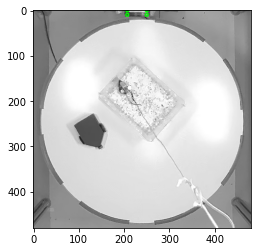

In [8]:
from autopipy.dlcObjectDetectors import BridgeDetector

for i,ses in enumerate(myProject.sessionList[34:35]):
    videoFile = ses.fileNames["arena_top.avi"] #Nice trick to get file names using a dict
    bridge640_480Model = "bridgeDetection_640_480-Allen-2021-02-10"
    configFile = "/adata/models/"+ bridge640_480Model+"/config.yaml"
    bridgeImageFile = ses.path+"/bridgeDetection.png"
    numFramesBridgeDetection=100
    skip=100
    bridgeD = BridgeDetector(pathConfigFile=configFile)
    bCoord = bridgeD.detectBridgeCoordinates(pathVideoFile=videoFile,numFrames=numFramesBridgeDetection, skip=skip)
    bridgeD.labelImage(pathVideoFile=videoFile,outputImageFile=bridgeImageFile)
    im = Image.open(bridgeImageFile)
    plt.imshow(im)
    plt.show()

## Process all sessions

Check which sessions we need to analyze.

In [16]:
ses.fileNames

{'log': '/adata/projects/autopi_ca1/mn5824/mn5824-20112020-0107/mn5824-20112020-0107.log',
 'protocol': '/adata/projects/autopi_ca1/mn5824/mn5824-20112020-0107/mn5824-20112020-0107.protocol',
 'arena_top.avi': '/adata/projects/autopi_ca1/mn5824/mn5824-20112020-0107/mn5824-20112020-0107.arena_top.avi',
 'arena_top.log': '/adata/projects/autopi_ca1/mn5824/mn5824-20112020-0107/mn5824-20112020-0107.arena_top.log',
 'arena_top.cropped.avi': '/adata/projects/autopi_ca1/mn5824/mn5824-20112020-0107/mn5824-20112020-0107.arena_top.cropped.avi',
 'mouseLeverPosition.csv': '/adata/projects/autopi_ca1/mn5824/mn5824-20112020-0107/mn5824-20112020-0107.mouseLeverPosition.csv',
 'arenaCoordinates': '/adata/projects/autopi_ca1/mn5824/mn5824-20112020-0107/arenaCoordinates',
 'bridgeCoordinates': '/adata/projects/autopi_ca1/mn5824/mn5824-20112020-0107/bridgeCoordinates'}

In [17]:
for i, ses in enumerate(myProject.sessionList):
    print(i, ses.name, os.path.exists(ses.fileNames["mouseLeverPosition.csv"]))

0 mn5824-20112020-0107 True
1 mn5824-22112020-0107 True
2 mn5824-24112020-0107 True
3 mn5824-02122020-0106 True
4 mn711-28012021-0106 True
5 mn711-30012021-0106 True
6 mn711-31012021-0107 True
7 mn711-01022021-0107 True
8 mn711-02022021-0108 True
9 mn711-03022021-0107 True
10 mn711-04022021-0107 True
11 mn2739-11022021-0107 True
12 mn2739-15022021-0105 True
13 mn2739-16022021-0106 True
14 mn2739-17022021-0106 True
15 mn2739-21022021-0106 True
16 mn3246-09042021-0106 True
17 mn3246-10042021-0106 True
18 mn3246-12042021-0106 True
19 mn3246-14042021-0106 True
20 mn1173-02052021-0107 True
21 mn1173-06052021-0107 True
22 mn1173-08052021-0107 True
23 mn1173-09052021-0108 True
24 mn1173-11052021-0108 True
25 TYY9524-25082021-0106 True
26 TYY9524-22082021-0106 True
27 TYY9524-20082021-0106 True
28 TYY9524-18082021-0106 True
29 TYY9524-16082021-0106 True
30 mn5618-07072021-0107 True
31 mn5618-09072021-0106 True
32 TYY5622-07092021-0106 True
33 TYY5622-17092021-0106 True
34 TYY5622-19092021-0106

In [11]:
for i, ses in enumerate(myProject.sessionList):
    print(i, ses.name, os.path.exists(ses.path+"/arenaBridgeDetectionCropped.png"))

0 mn5824-20112020-0107 True
1 mn5824-22112020-0107 True
2 mn5824-24112020-0107 True
3 mn5824-02122020-0106 True
4 mn711-28012021-0106 True
5 mn711-30012021-0106 True
6 mn711-31012021-0107 True
7 mn711-01022021-0107 True
8 mn711-02022021-0108 True
9 mn711-03022021-0107 True
10 mn711-04022021-0107 True
11 mn2739-11022021-0107 True
12 mn2739-15022021-0105 True
13 mn2739-16022021-0106 True
14 mn2739-17022021-0106 True
15 mn2739-21022021-0106 True
16 mn3246-09042021-0106 True
17 mn3246-10042021-0106 True
18 mn3246-12042021-0106 True
19 mn3246-14042021-0106 True
20 mn1173-02052021-0107 True
21 mn1173-06052021-0107 True
22 mn1173-08052021-0107 True
23 mn1173-09052021-0108 True
24 mn1173-11052021-0108 True
25 TYY9524-25082021-0106 True
26 TYY9524-22082021-0106 True
27 TYY9524-20082021-0106 True
28 TYY9524-18082021-0106 True
29 TYY9524-16082021-0106 True
30 mn5618-07072021-0107 True
31 mn5618-09072021-0106 True
32 TYY5622-07092021-0106 True
33 TYY5622-17092021-0106 True
34 TYY5622-19092021-0106

In [4]:
ses = myProject.sessionList[39]
ses
positionTrackingFromArenaTopVideo(ses,modelDir=dlcModelPath,arenaMinRadius=140,arenaMaxRadius=230, arenaCircleMethod="median")

Startint at 14:51:49
labelImage: /adata/projects/autopi_ca1/mn9686/mn9686-01112021-0106/arenaDetection.png
/tmp/tmpVid.avi created for bridge detection
Running dlc.analyze_video on /tmp/tmpVid.avi
Using snapshot-460000 for model /adata/models/bridgeDetection_640_480-Allen-2021-02-10/dlc-models/iteration-0/bridgeDetection_640_480Feb10-trainset95shuffle1


2022-02-04 14:53:35.898183: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2022-02-04 14:53:35.934631: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-04 14:53:35.934987: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.635GHz coreCount: 68 deviceMemorySize: 10.75GiB deviceMemoryBandwidth: 573.69GiB/s
2022-02-04 14:53:35.935877: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2022-02-04 14:53:35.951939: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-02-04 14:53:35.961366: I tensorflow/stream_executor/platfo

Starting to analyze %  /tmp/tmpVid.avi
/tmp  already exists!
Loading  /tmp/tmpVid.avi
Duration of video [s]:  33.33 , recorded with  30.0 fps!
Overall # of frames:  1000  found with (before cropping) frame dimensions:  480 480
Starting to extract posture


  0%|                                                  | 0/1000 [00:00<?, ?it/s]2022-02-04 14:53:39.780585: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2022-02-04 14:53:40.873078: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
1010it [00:14, 71.00it/s]                                                       


Saving results in /tmp...
The videos are analyzed. Now your research can truly start! 
 You can create labeled videos with 'create_labeled_video'
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.
dlc.loadPositionData() read data from /tmp/tmpVidDLC_resnet50_bridgeDetection_640_480Feb10shuffle1_460000.h5
dlc.loadPositionData() read data from /tmp/tmpVidDLC_resnet50_bridgeDetection_640_480Feb10shuffle1_460000.h5
Saving position data to /tmp/tmpVidDLC_resnet50_bridgeDetection_640_480Feb10shuffle1_460000.csv
dlc.loadPositionData() read data from /tmp/tmpVidDLC_resnet50_bridgeDetection_640_480Feb10shuffle1_460000.h5
Bridge coordinates: [[212   0]
 [212   9]
 [256   9]
 [256   0]]
labelImage: /adata/projects/autopi_ca1/mn9686/mn9686-01112021-0106/bridgeDetection.png
Time elapsed 0:02:04.449295
Cropping and masking 163806 frames in /adata/projects/autopi_ca

2022-02-04 15:03:32.558398: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-04 15:03:32.558593: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.635GHz coreCount: 68 deviceMemorySize: 10.75GiB deviceMemoryBandwidth: 573.69GiB/s
2022-02-04 15:03:32.558668: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2022-02-04 15:03:32.558693: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-02-04 15:03:32.558716: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2022-02-04 15:03:32.558741: I tensorflow/stream_executor/plat

Starting to analyze %  /adata/projects/autopi_ca1/mn9686/mn9686-01112021-0106/mn9686-01112021-0106.arena_top.cropped.avi
/adata/projects/autopi_ca1/mn9686/mn9686-01112021-0106  already exists!
Loading  /adata/projects/autopi_ca1/mn9686/mn9686-01112021-0106/mn9686-01112021-0106.arena_top.cropped.avi
Duration of video [s]:  5460.2 , recorded with  30.0 fps!
Overall # of frames:  163806  found with (before cropping) frame dimensions:  480 480
Starting to extract posture


  5%|█▊                                   | 8190/163806 [01:31<29:01, 89.38it/s]


The videos are analyzed. Now your research can truly start! 
 You can create labeled videos with 'create_labeled_video'
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.
/adata/projects/autopi_ca1/mn9686/mn9686-01112021-0106/mn9686-01112021-0106.arena_top.croppedDLC_resnet50_arena_topOct30shuffle1_950000.h5 does not exist
Run inferenceVideo first
/adata/projects/autopi_ca1/mn9686/mn9686-01112021-0106/mn9686-01112021-0106.arena_top.croppedDLC_resnet50_arena_topOct30shuffle1_950000.h5 does not exist
Run inferenceVideo first


AttributeError: 'MouseLeverDetector' object has no attribute 'out'

In [8]:
from autopipy.video_utilities import positionTrackingFromArenaTopVideo
#for i,ses in enumerate(myProject.sessionList[43:]):
for i,ses in enumerate(myProject.sessionList[43:]): # [ ses for ses in myProject.sessionList if not os.path.exists(ses.path+"/arenaBridgeDetectionCropped.png")]):
    print("************************************************")
    print("**********", i, ses.name, "*********************")
    print("************************************************")
    #ses = myProject.sessionList[4]
    print(ses.name)
    positionTrackingFromArenaTopVideo(ses,modelDir=dlcModelPath,arenaMinRadius=140,arenaMaxRadius=230, arenaCircleMethod="median")


************************************************
********** 0 mn9686-01112021-0106 *********************
************************************************
mn9686-01112021-0106
Startint at 20:53:20
labelImage: /adata/projects/autopi_ca1/mn9686/mn9686-01112021-0106/arenaDetection.png
/tmp/tmpVid.avi created for bridge detection
Running dlc.analyze_video on /tmp/tmpVid.avi
Using snapshot-460000 for model /adata/models/bridgeDetection_640_480-Allen-2021-02-10/dlc-models/iteration-0/bridgeDetection_640_480Feb10-trainset95shuffle1


2021-11-26 20:55:16.121152: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2021-11-26 20:55:16.151043: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-26 20:55:16.151323: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.635GHz coreCount: 68 deviceMemorySize: 10.75GiB deviceMemoryBandwidth: 573.69GiB/s
2021-11-26 20:55:16.152584: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2021-11-26 20:55:16.167386: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2021-11-26 20:55:16.176787: I tensorflow/stream_executor/platfo

Starting to analyze %  /tmp/tmpVid.avi
/tmp  already exists!
Loading  /tmp/tmpVid.avi
Duration of video [s]:  33.33 , recorded with  30.0 fps!
Overall # of frames:  1000  found with (before cropping) frame dimensions:  480 480
Starting to extract posture


  0%|                                                  | 0/1000 [00:00<?, ?it/s]2021-11-26 20:55:19.053456: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2021-11-26 20:55:20.000365: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
1010it [00:12, 78.33it/s]                                                       


Saving results in /tmp...
The videos are analyzed. Now your research can truly start! 
 You can create labeled videos with 'create_labeled_video'
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.
dlc.loadPositionData() read data from /tmp/tmpVidDLC_resnet50_bridgeDetection_640_480Feb10shuffle1_460000.h5
dlc.loadPositionData() read data from /tmp/tmpVidDLC_resnet50_bridgeDetection_640_480Feb10shuffle1_460000.h5
Saving position data to /tmp/tmpVidDLC_resnet50_bridgeDetection_640_480Feb10shuffle1_460000.csv
dlc.loadPositionData() read data from /tmp/tmpVidDLC_resnet50_bridgeDetection_640_480Feb10shuffle1_460000.h5
Bridge coordinates: [[212   0]
 [212   9]
 [256   9]
 [256   0]]
labelImage: /adata/projects/autopi_ca1/mn9686/mn9686-01112021-0106/bridgeDetection.png
Time elapsed 0:02:11.108045
Cropping and masking 163806 frames in /adata/projects/autopi_ca

2021-11-26 21:03:18.305120: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-26 21:03:18.305336: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.635GHz coreCount: 68 deviceMemorySize: 10.75GiB deviceMemoryBandwidth: 573.69GiB/s
2021-11-26 21:03:18.312782: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2021-11-26 21:03:18.312806: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2021-11-26 21:03:18.312820: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2021-11-26 21:03:18.312835: I tensorflow/stream_executor/plat

Starting to analyze %  /adata/projects/autopi_ca1/mn9686/mn9686-01112021-0106/mn9686-01112021-0106.arena_top.cropped.avi
/adata/projects/autopi_ca1/mn9686/mn9686-01112021-0106  already exists!
Loading  /adata/projects/autopi_ca1/mn9686/mn9686-01112021-0106/mn9686-01112021-0106.arena_top.cropped.avi
Duration of video [s]:  5460.2 , recorded with  30.0 fps!
Overall # of frames:  163806  found with (before cropping) frame dimensions:  480 480
Starting to extract posture


165438it [29:40, 92.90it/s]                                                     


Saving results in /adata/projects/autopi_ca1/mn9686/mn9686-01112021-0106...
The videos are analyzed. Now your research can truly start! 
 You can create labeled videos with 'create_labeled_video'
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.
dlc.loadPositionData() read data from /adata/projects/autopi_ca1/mn9686/mn9686-01112021-0106/mn9686-01112021-0106.arena_top.croppedDLC_resnet50_arena_topOct30shuffle1_950000.h5
dlc.loadPositionData() read data from /adata/projects/autopi_ca1/mn9686/mn9686-01112021-0106/mn9686-01112021-0106.arena_top.croppedDLC_resnet50_arena_topOct30shuffle1_950000.h5
Saving position data to /adata/projects/autopi_ca1/mn9686/mn9686-01112021-0106/mn9686-01112021-0106.arena_top.croppedDLC_resnet50_arena_topOct30shuffle1_950000.csv
dlc.loadPositionData() read data from /adata/projects/autopi_ca1/mn9686/mn9686-01112021-0106/mn968

2021-11-26 21:33:41.011753: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-26 21:33:41.011950: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.635GHz coreCount: 68 deviceMemorySize: 10.75GiB deviceMemoryBandwidth: 573.69GiB/s
2021-11-26 21:33:41.012049: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2021-11-26 21:33:41.012064: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2021-11-26 21:33:41.012078: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2021-11-26 21:33:41.012092: I tensorflow/stream_executor/plat

Starting to analyze %  /tmp/tmpVid.avi
/tmp  already exists!
Loading  /tmp/tmpVid.avi
Duration of video [s]:  33.33 , recorded with  30.0 fps!
Overall # of frames:  1000  found with (before cropping) frame dimensions:  480 480
Starting to extract posture


1010it [00:11, 91.72it/s]                                                       


Saving results in /tmp...
The videos are analyzed. Now your research can truly start! 
 You can create labeled videos with 'create_labeled_video'
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.
dlc.loadPositionData() read data from /tmp/tmpVidDLC_resnet50_bridgeDetection_480_480Jan23shuffle1_320000.h5
dlc.loadPositionData() read data from /tmp/tmpVidDLC_resnet50_bridgeDetection_480_480Jan23shuffle1_320000.h5
Saving position data to /tmp/tmpVidDLC_resnet50_bridgeDetection_480_480Jan23shuffle1_320000.csv
dlc.loadPositionData() read data from /tmp/tmpVidDLC_resnet50_bridgeDetection_480_480Jan23shuffle1_320000.h5
Bridge coordinates: [[212   0]
 [212   9]
 [262   9]
 [262   0]]
labelImage: /adata/projects/autopi_ca1/mn9686/mn9686-01112021-0106/bridgeDetectionCropped.png
labelImage: /adata/projects/autopi_ca1/mn9686/mn9686-01112021-0106/arenaBridgeDetect

To fix arena detection...


In [4]:
## Sessions to re-run with new network
sesNameList = ["mn7701-19122019-1216","mn7711-19122019-1429"]
for sesName in sesNameList:
    ses=myProject.getSession(sesName)
    positionTrackingFromArenaTopVideo(ses=ses,modelDir=myProject.dlcModelPath)

Startint at 10:15:52
labelImage: /adata/projects/autopi_behavior_2021/mn7701/mn7701-19122019-1216/arenaDetection.png
/tmp/tmpVid.avi created for bridge detection
Running dlc.analyze_video on /tmp/tmpVid.avi
Using snapshot-460000 for model /adata/models/bridgeDetection_640_480-Allen-2021-02-10/dlc-models/iteration-0/bridgeDetection_640_480Feb10-trainset95shuffle1
Initializing ResNet


  0%|          | 0/500 [00:00<?, ?it/s]

Starting to analyze %  /tmp/tmpVid.avi
/tmp  already exists!
Loading  /tmp/tmpVid.avi
Duration of video [s]:  16.67 , recorded with  30.0 fps!
Overall # of frames:  500  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


510it [00:08, 56.88it/s]                         


Saving results in /tmp...
The videos are analyzed. Now your research can truly start! 
 You can create labeled videos with 'create_labeled_video'
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.
dlc.loadPositionData() read data from /tmp/tmpVidDLC_resnet_50_bridgeDetection_640_480Feb10shuffle1_460000.h5
dlc.loadPositionData() read data from /tmp/tmpVidDLC_resnet_50_bridgeDetection_640_480Feb10shuffle1_460000.h5
Saving position data to /tmp/tmpVidDLC_resnet_50_bridgeDetection_640_480Feb10shuffle1_460000.csv
dlc.loadPositionData() read data from /tmp/tmpVidDLC_resnet_50_bridgeDetection_640_480Feb10shuffle1_460000.h5
Bridge coordinates: [[293   0]
 [293  30]
 [335  30]
 [335   0]]
labelImage: /adata/projects/autopi_behavior_2021/mn7701/mn7701-19122019-1216/bridgeDetection.png
Time elapsed 0:00:21.893074
Cropping and masking 106253 frames in /adata/proj

  0%|          | 0/106253 [00:00<?, ?it/s]

Starting to analyze %  /adata/projects/autopi_behavior_2021/mn7701/mn7701-19122019-1216/mn7701-19122019-1216.arena_top.cropped.avi
/adata/projects/autopi_behavior_2021/mn7701/mn7701-19122019-1216  already exists!
Loading  /adata/projects/autopi_behavior_2021/mn7701/mn7701-19122019-1216/mn7701-19122019-1216.arena_top.cropped.avi
Duration of video [s]:  3541.77 , recorded with  30.0 fps!
Overall # of frames:  106253  found with (before cropping) frame dimensions:  480 480
Starting to extract posture


107262it [19:31, 91.55it/s]                            


Saving results in /adata/projects/autopi_behavior_2021/mn7701/mn7701-19122019-1216...
The videos are analyzed. Now your research can truly start! 
 You can create labeled videos with 'create_labeled_video'
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.
dlc.loadPositionData() read data from /adata/projects/autopi_behavior_2021/mn7701/mn7701-19122019-1216/mn7701-19122019-1216.arena_top.croppedDLC_resnet_50_arena_topOct30shuffle1_950000.h5
dlc.loadPositionData() read data from /adata/projects/autopi_behavior_2021/mn7701/mn7701-19122019-1216/mn7701-19122019-1216.arena_top.croppedDLC_resnet_50_arena_topOct30shuffle1_950000.h5
Saving position data to /adata/projects/autopi_behavior_2021/mn7701/mn7701-19122019-1216/mn7701-19122019-1216.arena_top.croppedDLC_resnet_50_arena_topOct30shuffle1_950000.csv
dlc.loadPositionData() read data from /adata/projects/a

  0%|          | 0/500 [00:00<?, ?it/s]

Starting to analyze %  /tmp/tmpVid.avi
/tmp  already exists!
Loading  /tmp/tmpVid.avi
Duration of video [s]:  16.67 , recorded with  30.0 fps!
Overall # of frames:  500  found with (before cropping) frame dimensions:  480 480
Starting to extract posture


510it [00:05, 87.12it/s]                         


Saving results in /tmp...
The videos are analyzed. Now your research can truly start! 
 You can create labeled videos with 'create_labeled_video'
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.
dlc.loadPositionData() read data from /tmp/tmpVidDLC_resnet_50_bridgeDetection_480_480Jan23shuffle1_320000.h5
dlc.loadPositionData() read data from /tmp/tmpVidDLC_resnet_50_bridgeDetection_480_480Jan23shuffle1_320000.h5
Saving position data to /tmp/tmpVidDLC_resnet_50_bridgeDetection_480_480Jan23shuffle1_320000.csv
dlc.loadPositionData() read data from /tmp/tmpVidDLC_resnet_50_bridgeDetection_480_480Jan23shuffle1_320000.h5
Bridge coordinates: [[218   0]
 [218  30]
 [258  30]
 [258   0]]
labelImage: /adata/projects/autopi_behavior_2021/mn7701/mn7701-19122019-1216/bridgeDetectionCropped.png
labelImage: /adata/projects/autopi_behavior_2021/mn7701/mn7701-1912201

  0%|          | 0/500 [00:00<?, ?it/s]

Starting to analyze %  /tmp/tmpVid.avi
/tmp  already exists!
Loading  /tmp/tmpVid.avi
Duration of video [s]:  16.67 , recorded with  30.0 fps!
Overall # of frames:  500  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


510it [00:07, 67.45it/s]                         


Saving results in /tmp...
The videos are analyzed. Now your research can truly start! 
 You can create labeled videos with 'create_labeled_video'
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.
dlc.loadPositionData() read data from /tmp/tmpVidDLC_resnet_50_bridgeDetection_640_480Feb10shuffle1_460000.h5
dlc.loadPositionData() read data from /tmp/tmpVidDLC_resnet_50_bridgeDetection_640_480Feb10shuffle1_460000.h5
Saving position data to /tmp/tmpVidDLC_resnet_50_bridgeDetection_640_480Feb10shuffle1_460000.csv
dlc.loadPositionData() read data from /tmp/tmpVidDLC_resnet_50_bridgeDetection_640_480Feb10shuffle1_460000.h5
Bridge coordinates: [[293   0]
 [293  29]
 [336  29]
 [336   0]]
labelImage: /adata/projects/autopi_behavior_2021/mn7711/mn7711-19122019-1429/bridgeDetection.png
Time elapsed 0:00:19.858398
Cropping and masking 115401 frames in /adata/proj

  0%|          | 0/115401 [00:00<?, ?it/s]

Starting to analyze %  /adata/projects/autopi_behavior_2021/mn7711/mn7711-19122019-1429/mn7711-19122019-1429.arena_top.cropped.avi
/adata/projects/autopi_behavior_2021/mn7711/mn7711-19122019-1429  already exists!
Loading  /adata/projects/autopi_behavior_2021/mn7711/mn7711-19122019-1429/mn7711-19122019-1429.arena_top.cropped.avi
Duration of video [s]:  3846.7 , recorded with  30.0 fps!
Overall # of frames:  115401  found with (before cropping) frame dimensions:  480 480
Starting to extract posture


116554it [21:00, 92.47it/s]                            


Saving results in /adata/projects/autopi_behavior_2021/mn7711/mn7711-19122019-1429...
The videos are analyzed. Now your research can truly start! 
 You can create labeled videos with 'create_labeled_video'
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.
dlc.loadPositionData() read data from /adata/projects/autopi_behavior_2021/mn7711/mn7711-19122019-1429/mn7711-19122019-1429.arena_top.croppedDLC_resnet_50_arena_topOct30shuffle1_950000.h5
dlc.loadPositionData() read data from /adata/projects/autopi_behavior_2021/mn7711/mn7711-19122019-1429/mn7711-19122019-1429.arena_top.croppedDLC_resnet_50_arena_topOct30shuffle1_950000.h5
Saving position data to /adata/projects/autopi_behavior_2021/mn7711/mn7711-19122019-1429/mn7711-19122019-1429.arena_top.croppedDLC_resnet_50_arena_topOct30shuffle1_950000.csv
dlc.loadPositionData() read data from /adata/projects/a

  0%|          | 0/500 [00:00<?, ?it/s]

Starting to analyze %  /tmp/tmpVid.avi
/tmp  already exists!
Loading  /tmp/tmpVid.avi
Duration of video [s]:  16.67 , recorded with  30.0 fps!
Overall # of frames:  500  found with (before cropping) frame dimensions:  480 480
Starting to extract posture


510it [00:05, 85.07it/s]                         


Saving results in /tmp...
The videos are analyzed. Now your research can truly start! 
 You can create labeled videos with 'create_labeled_video'
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.
dlc.loadPositionData() read data from /tmp/tmpVidDLC_resnet_50_bridgeDetection_480_480Jan23shuffle1_320000.h5
dlc.loadPositionData() read data from /tmp/tmpVidDLC_resnet_50_bridgeDetection_480_480Jan23shuffle1_320000.h5
Saving position data to /tmp/tmpVidDLC_resnet_50_bridgeDetection_480_480Jan23shuffle1_320000.csv
dlc.loadPositionData() read data from /tmp/tmpVidDLC_resnet_50_bridgeDetection_480_480Jan23shuffle1_320000.h5
Bridge coordinates: [[218   0]
 [218  29]
 [260  29]
 [260   0]]
labelImage: /adata/projects/autopi_behavior_2021/mn7711/mn7711-19122019-1429/bridgeDetectionCropped.png
labelImage: /adata/projects/autopi_behavior_2021/mn7711/mn7711-1912201

## Group of sessions
And to run a group of sessions, simply run this in a for loop. I will save the session name in a file to keep track of what is done.

pc73 from home.
Friday: I did 0:10 as a first try and worked great. 5%
Friday: I tried 10:40 overnight to test overnight vpn connection, manage to do 32 sessions. 

It is too slow if run only on one computer.
pc59 and pc 73

* pc73: [32:100]
* pc59: [100:]

In [6]:
for ses in myProject.sessionList[7:] :
    positionTrackingFromArenaTopVideo(ses=ses,modelDir=myProject.dlcModelPath)
   # text_file = open(myProject.dataPath+"/results/dlcDone", "a")
   # text_file.write("{}\n".format(ses.name))
   # text_file.close()

Startint at 21:17:46
labelImage: /adata/projects/autopi_behavior_2021/mn9686/mn9686-16052021-1443/arenaDetection.png
/tmp/tmpVid.avi created for bridge detection
Running dlc.analyze_video on /tmp/tmpVid.avi
Using snapshot-460000 for model /adata/models/bridgeDetection_640_480-Allen-2021-02-10/dlc-models/iteration-0/bridgeDetection_640_480Feb10-trainset95shuffle1
Initializing ResNet


  0%|          | 0/500 [00:00<?, ?it/s]

Starting to analyze %  /tmp/tmpVid.avi
/tmp  already exists!
Loading  /tmp/tmpVid.avi
Duration of video [s]:  16.67 , recorded with  30.0 fps!
Overall # of frames:  500  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


510it [00:08, 59.24it/s]                         


Saving results in /tmp...
The videos are analyzed. Now your research can truly start! 
 You can create labeled videos with 'create_labeled_video'
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.
dlc.loadPositionData() read data from /tmp/tmpVidDLC_resnet_50_bridgeDetection_640_480Feb10shuffle1_460000.h5
dlc.loadPositionData() read data from /tmp/tmpVidDLC_resnet_50_bridgeDetection_640_480Feb10shuffle1_460000.h5
Saving position data to /tmp/tmpVidDLC_resnet_50_bridgeDetection_640_480Feb10shuffle1_460000.csv
dlc.loadPositionData() read data from /tmp/tmpVidDLC_resnet_50_bridgeDetection_640_480Feb10shuffle1_460000.h5
Bridge coordinates: [[270   0]
 [270  22]
 [323  22]
 [323   0]]
labelImage: /adata/projects/autopi_behavior_2021/mn9686/mn9686-16052021-1443/bridgeDetection.png
Time elapsed 0:00:20.049256
Cropping and masking 157232 frames in /adata/proj

  0%|          | 0/157232 [00:00<?, ?it/s]

Starting to analyze %  /adata/projects/autopi_behavior_2021/mn9686/mn9686-16052021-1443/mn9686-16052021-1443.arena_top.cropped.avi
/adata/projects/autopi_behavior_2021/mn9686/mn9686-16052021-1443  already exists!
Loading  /adata/projects/autopi_behavior_2021/mn9686/mn9686-16052021-1443/mn9686-16052021-1443.arena_top.cropped.avi
Duration of video [s]:  5241.07 , recorded with  30.0 fps!
Overall # of frames:  157232  found with (before cropping) frame dimensions:  480 480
Starting to extract posture


158772it [29:31, 89.62it/s]                            


Saving results in /adata/projects/autopi_behavior_2021/mn9686/mn9686-16052021-1443...
The videos are analyzed. Now your research can truly start! 
 You can create labeled videos with 'create_labeled_video'
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.
dlc.loadPositionData() read data from /adata/projects/autopi_behavior_2021/mn9686/mn9686-16052021-1443/mn9686-16052021-1443.arena_top.croppedDLC_resnet_50_arena_topOct30shuffle1_950000.h5
dlc.loadPositionData() read data from /adata/projects/autopi_behavior_2021/mn9686/mn9686-16052021-1443/mn9686-16052021-1443.arena_top.croppedDLC_resnet_50_arena_topOct30shuffle1_950000.h5
Saving position data to /adata/projects/autopi_behavior_2021/mn9686/mn9686-16052021-1443/mn9686-16052021-1443.arena_top.croppedDLC_resnet_50_arena_topOct30shuffle1_950000.csv
dlc.loadPositionData() read data from /adata/projects/a

  0%|          | 0/500 [00:00<?, ?it/s]

Starting to analyze %  /tmp/tmpVid.avi
/tmp  already exists!
Loading  /tmp/tmpVid.avi
Duration of video [s]:  16.67 , recorded with  30.0 fps!
Overall # of frames:  500  found with (before cropping) frame dimensions:  480 480
Starting to extract posture


510it [00:06, 84.04it/s]                         


Saving results in /tmp...
The videos are analyzed. Now your research can truly start! 
 You can create labeled videos with 'create_labeled_video'
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.
dlc.loadPositionData() read data from /tmp/tmpVidDLC_resnet_50_bridgeDetection_480_480Jan23shuffle1_320000.h5
dlc.loadPositionData() read data from /tmp/tmpVidDLC_resnet_50_bridgeDetection_480_480Jan23shuffle1_320000.h5
Saving position data to /tmp/tmpVidDLC_resnet_50_bridgeDetection_480_480Jan23shuffle1_320000.csv
dlc.loadPositionData() read data from /tmp/tmpVidDLC_resnet_50_bridgeDetection_480_480Jan23shuffle1_320000.h5
Bridge coordinates: [[209   0]
 [209  24]
 [262  24]
 [262   0]]
labelImage: /adata/projects/autopi_behavior_2021/mn9686/mn9686-16052021-1443/bridgeDetectionCropped.png
labelImage: /adata/projects/autopi_behavior_2021/mn9686/mn9686-1605202

  0%|          | 0/500 [00:00<?, ?it/s]

Starting to analyze %  /tmp/tmpVid.avi
/tmp  already exists!
Loading  /tmp/tmpVid.avi
Duration of video [s]:  16.67 , recorded with  30.0 fps!
Overall # of frames:  500  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


510it [00:07, 67.90it/s]                         


Saving results in /tmp...
The videos are analyzed. Now your research can truly start! 
 You can create labeled videos with 'create_labeled_video'
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.
dlc.loadPositionData() read data from /tmp/tmpVidDLC_resnet_50_bridgeDetection_640_480Feb10shuffle1_460000.h5
dlc.loadPositionData() read data from /tmp/tmpVidDLC_resnet_50_bridgeDetection_640_480Feb10shuffle1_460000.h5
Saving position data to /tmp/tmpVidDLC_resnet_50_bridgeDetection_640_480Feb10shuffle1_460000.csv
dlc.loadPositionData() read data from /tmp/tmpVidDLC_resnet_50_bridgeDetection_640_480Feb10shuffle1_460000.h5
Bridge coordinates: [[270   0]
 [270  24]
 [323  24]
 [323   0]]
labelImage: /adata/projects/autopi_behavior_2021/TYY5630/TYY5630-16052021-1810/bridgeDetection.png
Time elapsed 0:00:18.316951
Cropping and masking -276701161105643264 frames

  0%|          | 0/112620 [00:00<?, ?it/s]

Starting to analyze %  /adata/projects/autopi_behavior_2021/TYY5630/TYY5630-16052021-1810/TYY5630-16052021-1810.arena_top.cropped.avi
/adata/projects/autopi_behavior_2021/TYY5630/TYY5630-16052021-1810  already exists!
Loading  /adata/projects/autopi_behavior_2021/TYY5630/TYY5630-16052021-1810/TYY5630-16052021-1810.arena_top.cropped.avi
Duration of video [s]:  3754.0 , recorded with  30.0 fps!
Overall # of frames:  112620  found with (before cropping) frame dimensions:  480 480
Starting to extract posture


113726it [20:06, 94.24it/s]                            


Saving results in /adata/projects/autopi_behavior_2021/TYY5630/TYY5630-16052021-1810...
The videos are analyzed. Now your research can truly start! 
 You can create labeled videos with 'create_labeled_video'
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.
dlc.loadPositionData() read data from /adata/projects/autopi_behavior_2021/TYY5630/TYY5630-16052021-1810/TYY5630-16052021-1810.arena_top.croppedDLC_resnet_50_arena_topOct30shuffle1_950000.h5
dlc.loadPositionData() read data from /adata/projects/autopi_behavior_2021/TYY5630/TYY5630-16052021-1810/TYY5630-16052021-1810.arena_top.croppedDLC_resnet_50_arena_topOct30shuffle1_950000.h5
Saving position data to /adata/projects/autopi_behavior_2021/TYY5630/TYY5630-16052021-1810/TYY5630-16052021-1810.arena_top.croppedDLC_resnet_50_arena_topOct30shuffle1_950000.csv
dlc.loadPositionData() read data from /adata

  0%|          | 0/500 [00:00<?, ?it/s]

Starting to analyze %  /tmp/tmpVid.avi
/tmp  already exists!
Loading  /tmp/tmpVid.avi
Duration of video [s]:  16.67 , recorded with  30.0 fps!
Overall # of frames:  500  found with (before cropping) frame dimensions:  480 480
Starting to extract posture


510it [00:05, 86.61it/s]                         


Saving results in /tmp...
The videos are analyzed. Now your research can truly start! 
 You can create labeled videos with 'create_labeled_video'
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.
dlc.loadPositionData() read data from /tmp/tmpVidDLC_resnet_50_bridgeDetection_480_480Jan23shuffle1_320000.h5
dlc.loadPositionData() read data from /tmp/tmpVidDLC_resnet_50_bridgeDetection_480_480Jan23shuffle1_320000.h5
Saving position data to /tmp/tmpVidDLC_resnet_50_bridgeDetection_480_480Jan23shuffle1_320000.csv
dlc.loadPositionData() read data from /tmp/tmpVidDLC_resnet_50_bridgeDetection_480_480Jan23shuffle1_320000.h5
Bridge coordinates: [[205   0]
 [205  23]
 [256  23]
 [256   0]]
labelImage: /adata/projects/autopi_behavior_2021/TYY5630/TYY5630-16052021-1810/bridgeDetectionCropped.png
labelImage: /adata/projects/autopi_behavior_2021/TYY5630/TYY5630-160

  0%|          | 0/500 [00:00<?, ?it/s]

Starting to analyze %  /tmp/tmpVid.avi
/tmp  already exists!
Loading  /tmp/tmpVid.avi
Duration of video [s]:  16.67 , recorded with  30.0 fps!
Overall # of frames:  500  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


510it [00:07, 68.62it/s]                         


Saving results in /tmp...
The videos are analyzed. Now your research can truly start! 
 You can create labeled videos with 'create_labeled_video'
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.
dlc.loadPositionData() read data from /tmp/tmpVidDLC_resnet_50_bridgeDetection_640_480Feb10shuffle1_460000.h5
dlc.loadPositionData() read data from /tmp/tmpVidDLC_resnet_50_bridgeDetection_640_480Feb10shuffle1_460000.h5
Saving position data to /tmp/tmpVidDLC_resnet_50_bridgeDetection_640_480Feb10shuffle1_460000.csv
dlc.loadPositionData() read data from /tmp/tmpVidDLC_resnet_50_bridgeDetection_640_480Feb10shuffle1_460000.h5
Bridge coordinates: [[270   0]
 [270  23]
 [322  23]
 [322   0]]
labelImage: /adata/projects/autopi_behavior_2021/TYY5622/TYY5622-16052021-1621/bridgeDetection.png
Time elapsed 0:00:18.260521
Cropping and masking 102025 frames in /adata/pr

  0%|          | 0/102025 [00:00<?, ?it/s]

Starting to analyze %  /adata/projects/autopi_behavior_2021/TYY5622/TYY5622-16052021-1621/TYY5622-16052021-1621.arena_top.cropped.avi
/adata/projects/autopi_behavior_2021/TYY5622/TYY5622-16052021-1621  already exists!
Loading  /adata/projects/autopi_behavior_2021/TYY5622/TYY5622-16052021-1621/TYY5622-16052021-1621.arena_top.cropped.avi
Duration of video [s]:  3400.83 , recorded with  30.0 fps!
Overall # of frames:  102025  found with (before cropping) frame dimensions:  480 480
Starting to extract posture


103020it [18:14, 94.13it/s]                            


Saving results in /adata/projects/autopi_behavior_2021/TYY5622/TYY5622-16052021-1621...
The videos are analyzed. Now your research can truly start! 
 You can create labeled videos with 'create_labeled_video'
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.
dlc.loadPositionData() read data from /adata/projects/autopi_behavior_2021/TYY5622/TYY5622-16052021-1621/TYY5622-16052021-1621.arena_top.croppedDLC_resnet_50_arena_topOct30shuffle1_950000.h5
dlc.loadPositionData() read data from /adata/projects/autopi_behavior_2021/TYY5622/TYY5622-16052021-1621/TYY5622-16052021-1621.arena_top.croppedDLC_resnet_50_arena_topOct30shuffle1_950000.h5
Saving position data to /adata/projects/autopi_behavior_2021/TYY5622/TYY5622-16052021-1621/TYY5622-16052021-1621.arena_top.croppedDLC_resnet_50_arena_topOct30shuffle1_950000.csv
dlc.loadPositionData() read data from /adata

  0%|          | 0/500 [00:00<?, ?it/s]

Starting to analyze %  /tmp/tmpVid.avi
/tmp  already exists!
Loading  /tmp/tmpVid.avi
Duration of video [s]:  16.67 , recorded with  30.0 fps!
Overall # of frames:  500  found with (before cropping) frame dimensions:  480 480
Starting to extract posture


510it [00:05, 90.44it/s]                         


Saving results in /tmp...
The videos are analyzed. Now your research can truly start! 
 You can create labeled videos with 'create_labeled_video'
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.
dlc.loadPositionData() read data from /tmp/tmpVidDLC_resnet_50_bridgeDetection_480_480Jan23shuffle1_320000.h5
dlc.loadPositionData() read data from /tmp/tmpVidDLC_resnet_50_bridgeDetection_480_480Jan23shuffle1_320000.h5
Saving position data to /tmp/tmpVidDLC_resnet_50_bridgeDetection_480_480Jan23shuffle1_320000.csv
dlc.loadPositionData() read data from /tmp/tmpVidDLC_resnet_50_bridgeDetection_480_480Jan23shuffle1_320000.h5
Bridge coordinates: [[213   0]
 [213  23]
 [264  23]
 [264   0]]
labelImage: /adata/projects/autopi_behavior_2021/TYY5622/TYY5622-16052021-1621/bridgeDetectionCropped.png
labelImage: /adata/projects/autopi_behavior_2021/TYY5622/TYY5622-160

In [ ]:
for ses in myProject.sessionList[100:] :
    positionTrackingFromArenaTopVideo(ses=ses,modelDir=myProject.dlcModelPath)
    text_file = open(myProject.dataPath+"/results/dlcDone", "a")
    text_file.write("{}\n".format(ses.name))
    text_file.close()

## Check that all went fine

First we will make sure that we have all session names in the `dlcDone` file.

In [3]:
done = pd.read_csv(myProject.dataPath+"/results/dlcDone",header=None)
sessionNamesTesting
print("Number of sessions: {}, processed sessions: {}".format(len(sessionNamesTesting),len(done)))
if len(sessionNamesTesting) > len(done) :
    print("Missing sessions are:")
    print(sessionNamesTesting.sessionName[~sessionNamesTesting.sessionName.isin(done[0])])

if np.all(sessionNamesTesting.sessionName.isin(done[0])) :
    print("All sessions processed")

Number of sessions: 187, processed sessions: 188
All sessions processed


## Check bridge and arena detection

The bridge and arena coordinates are critical for the subsequent analysis. We will make a folder containing an image of the detection for each session. One can then quickly scroll through the images to identify any problematic case.

In [13]:
# create a directory for the images
directory = myProject.dataPath + "/results/arenaBridgeDetectionImages"
try:
    os.stat(directory)
except:
    os.mkdir(directory)       

In [14]:
from shutil import copyfile

for ses in myProject.sessionList:
    src = ses.path + "/arenaBridgeDetectionCropped.png"
    dst = directory + "/" + ses.name + ".png"
    if not os.path.isfile(src):
        print (src + " does not exist")
        break
    try:
        copyfile(src, dst)
    except:
        print("error copying the file for " + ses.name )


# Rerun problematic sessions

I put the sessions with problems in a file in the `results/redo`

The main problem was the arena detection that was not perfect.

In [15]:
projectName="autopi_behavior_2021"
dataPath="/adata/projects/autopi_behavior_2021"
dlcModelPath="/adata/models"
bridgeModel1 ="bridgeDetection_640_480-Allen-2021-02-10"
mouseLeverModel ="arena_top-Allen-2019-10-30"
bridgeModel2 = "bridgeDetection_480_480-Allen-2021-01-23"
arenaMinRadius= 190
arenaMaxRadius= 230

myProject = Project(name=projectName,dataPath=dataPath,dlcModelPath=dlcModelPath)

# read a file with the session names
fn=myProject.dataPath+"/redo"
print("Reading " + fn)
sessionNamesTesting = pd.read_csv(fn) # this will be a pandas dataframe

# create a list of session object in the project object
myProject.createSessionList(sessionNameList=sessionNamesTesting.sessionName.to_list())
print("We have {} recording sessions".format(len(myProject.sessionList)))

Project name: autopi_behavior_2021
dataPath: /adata/projects/autopi_behavior_2021
dlcModelPath: /adata/models
Reading /adata/projects/autopi_behavior_2021/redo
We have 4 recording sessions


In [3]:
directory = myProject.dataPath + "/results/arenaDetectionImages"
try:
    os.stat(directory)
except:
    os.mkdir(directory)   

In [17]:
from autopipy.cvObjectDetectors import ArenaDetector
from datetime import datetime

for ses in myProject.sessionList :
    positionTrackingFromArenaTopVideo(ses=ses,modelDir=myProject.dlcModelPath,
                                      bridge640_480Model = bridgeModel1,
                                      mouseLeverModel = mouseLeverModel,
                                      bridge480_480Model = bridgeModel2,
                                      arenaMinRadius=arenaMinRadius , arenaMaxRadius=arenaMaxRadius,
                                      arenaCircleMethod="median")
   

TypeError: positionTrackingFromArenaTopVideo() got an unexpected keyword argument 'arenaCircleMethod'

In [23]:
from autopipy.cvObjectDetectors import ArenaDetector
from autopipy.dlcObjectDetectors import BridgeDetector
from autopipy.dlcObjectDetectors import MouseLeverDetector
from autopipy.video_utilities import arenaBridgeDetectionImage
from datetime import datetime

modelDir="/adata/models"
bridge640_480Model = "bridgeDetection_640_480-Allen-2021-02-10"
mouseLeverModel = "arena_top-Allen-2019-10-30"
bridge480_480Model = "bridgeDetection_480_480-Allen-2021-01-23"
arenaMinRadius= 180
arenaMaxRadius= 230
arenaCircleMethod = "min"
numFramesArenaDetection=500
numFramesBridgeDetection=500

print(modelDir)
print(mouseLeverModel)
configFile=modelDir+"/"+ mouseLeverModel + "/config.yaml"


for ses in [myProject.sessionList[0]] :
    
    videoFile=ses.fileNames["arena_top.avi"]
    croppedVideoFile = os.path.splitext(videoFile)[0]+".cropped.avi"
    arenaImageFile=ses.path+"/arenaDetectionCropped.png"
    bridge480_480Model=bridgeModel2
    modelDir = dlcModelPath
    
    
    arenaD = ArenaDetector()
    aCoord = arenaD.detectArenaCoordinates(pathVideoFile=croppedVideoFile, minRadius=arenaMinRadius, 
                                  maxRadius=arenaMaxRadius, numFrames=100, blur=11, circleMethod='median')
    arenaD.labelImage(pathVideoFile=croppedVideoFile,outputImageFile=arenaImageFile)
    np.savetxt(ses.fileNames["arenaCoordinates"],aCoord,delimiter=",") 


    configFile=modelDir+"/"+ mouseLeverModel + "/config.yaml"
    if not os.path.isfile(configFile):
        print(configFile+ " is missing")
    mouseLeverD = MouseLeverDetector(pathConfigFile=configFile)
    # save position data to file
    mouseLeverD.savePositionOrientationToFile(pathVideoFile=croppedVideoFile, 
                                              fileName = ses.fileNames["mouseLeverPosition.csv"])
    
    
    
    configFile = modelDir + "/" + bridge480_480Model + "/config.yaml"
    if not os.path.isfile(configFile):
        print(configFile+ " is missing")
    bridgeImageFile = ses.path+"/bridgeDetectionCropped.png"
    bridgeD = BridgeDetector(pathConfigFile=configFile)
    bCoord = bridgeD.detectBridgeCoordinates(pathVideoFile=croppedVideoFile,numFrames=100, skip=30)
    bridgeD.labelImage(pathVideoFile=videoFile,outputImageFile=bridgeImageFile)
    np.savetxt(ses.fileNames["bridgeCoordinates"],bCoord,delimiter=",")
    
    outputImageFile=ses.path+"/arenaBridgeDetectionCropped.png"
    arenaBridgeDetectionImage(pathVideoFile=croppedVideoFile,
                              outputImageFile=outputImageFile,
                              arenaCoordinates = aCoord,
                              bridgeCoordinates = bCoord)

/adata/models
arena_top-Allen-2019-10-30
labelImage: /adata/projects/autopi_behavior_2021/mn4656/mn4656-30092019-2001/arenaDetectionCropped.png
dlc.loadPositionData() read data from /adata/projects/autopi_behavior_2021/mn4656/mn4656-30092019-2001/mn4656-30092019-2001.arena_top.croppedDLC_resnet_50_arena_topOct30shuffle1_1030000.h5
/tmp/tmpVid.avi created for bridge detection
Running dlc.analyze_video on /tmp/tmpVid.avi
Using snapshot-420000 for model /adata/models/bridgeDetection_480_480-Allen-2021-01-23/dlc-models/iteration-0/bridgeDetection_480_480Jan23-trainset90shuffle1
Initializing ResNet


  0%|          | 0/100 [00:00<?, ?it/s]

Starting to analyze %  /tmp/tmpVid.avi
/tmp  already exists!
Loading  /tmp/tmpVid.avi
Duration of video [s]:  3.33 , recorded with  30.0 fps!
Overall # of frames:  100  found with (before cropping) frame dimensions:  480 480
Starting to extract posture


110it [00:01, 59.72it/s]                         


Detected frames:  100
Saving results in /tmp...
The videos are analyzed. Now your research can truly start! 
 You can create labeled videos with 'create_labeled_video'
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.
dlc.loadPositionData() read data from /tmp/tmpVidDLC_resnet_50_bridgeDetection_480_480Jan23shuffle1_420000.h5
dlc.loadPositionData() read data from /tmp/tmpVidDLC_resnet_50_bridgeDetection_480_480Jan23shuffle1_420000.h5
Saving position data to /tmp/tmpVidDLC_resnet_50_bridgeDetection_480_480Jan23shuffle1_420000.csv
dlc.loadPositionData() read data from /tmp/tmpVidDLC_resnet_50_bridgeDetection_480_480Jan23shuffle1_420000.h5
Bridge coordinates: [[220   0]
 [220  24]
 [259  24]
 [259   0]]
labelImage: /adata/projects/autopi_behavior_2021/mn4656/mn4656-30092019-2001/bridgeDetectionCropped.png
labelImage: /adata/projects/autopi_behavior_2021